In [1]:
import editdistance
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from more_itertools import windowed
tqdm.pandas()

In [2]:
def get_ngrams(text: str, n: int = 3, step=1) -> str:
    """

    :param text:
    :param n:
    :param step:
    :return:
    """

    output = []

    # split the sentence in tokens.
    tokens = text.split()

    # if only one token, then we only have BOS and EOS tags
    if len(tokens) == 1:

        chars = ['<BOS>'] + list(text) + ['<EOS>']
        text = ' '.join(
            [''.join(t) for t in windowed(seq=chars, n=3, step=1)])
        output.append(text)

    # We have more than 1 tokens. So we need 3 kind of tags:
    # BOS: beginning of sentence
    # IOS: inside of sentence
    # EOS: end of sentence
    else:
        # extracting the first token, a list of the inside tokens, and the
        # last token. We handle each one differently
        first, *inside, last = tokens

        # in the first token we put BOS tag in the beginning of the token
        # and IOS at the end, since the sentence is not over.
        # We also split to first token to it's characters, so we can get
        # the n-grams.
        first_chars = ['<BOS>'] + list(first) + ['<IOS>']

        # create the n-gram texts and join them back together with a ' '
        first_chars = ' '.join(
            [''.join(t)
             for t in windowed(seq=first_chars, n=n, step=step)])

        # append the "n-gramed" token to the output list
        output.append(first_chars)

        for ins_token in inside:
            # for each of the inside tokens use only the IOS tags
            # we do the same procedure as in the first token.
            inside_chars = ['<IOS>'] + list(ins_token) + ['<IOS>']

            inside_chars = ' '.join(
                [''.join(t) for t in
                 windowed(seq=inside_chars, n=n, step=step)])

            output.append(inside_chars)

        # for the last token we use IOS and EOS tags.
        # Same procedure as before.
        last_chars = ['<IOS>'] + list(last) + ['<EOS>']

        last_chars = ' '.join(
            [''.join(t) for t in windowed(seq=last_chars, n=3, step=1)])

        output.append(last_chars)

    return ' '.join(output)

In [3]:
# read dataset
df = pd.read_csv('../data/all_countries_filtered_columns.csv',
#                  nrows=10000
                )
# convert NaN to None
df = df.where((pd.notnull(df)), None)
# drop the rows with empty toponym
df.dropna(subset=['name'], inplace=True)
# calculate the toponym length
df['name_len'] = df['name'].str.len()
# convert to lowercase all toponyms
df['name'] = df['name'].str.lower()
# convert to lowercase all alternate names
df['alternate_names'] = df['alternate_names'].str.lower()
# get the list of alternate names for each row
df['alternate_names'] = df['alternate_names'].progress_apply(lambda x: x.split(',') if x else [])
# count the number of alternate names 
df['n_alternates'] = df['alternate_names'].progress_apply(len)

df.head()

/home/gperakis/.local/share/virtualenvs/LGM-SimilarityLearning-L8_qfM0A/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
100%|██████████| 11947366/11947366 [00:10<00:00, 1128623.61it/s]


,geonameid,name,ascii_name,alternate_names,country_code,cc2,name_len,n_alternates
0,2986043,pic de font blanca,Pic de Font Blanca,"[pic de font blanca, pic du port]",AD,None,18,2
1,2994701,roc mélé,Roc Mele,"[roc mele, roc meler, roc mélé]",AD,"AD,FR",8,3
2,3007683,pic des langounelles,Pic des Langounelles,[pic des langounelles],AD,"AD,FR",20,1
3,3017832,pic de les abelletes,Pic de les Abelletes,"[pic de la font-negre, pic de la font-nègre, p...",AD,FR,20,3
4,3017833,estany de les abelletes,Estany de les Abelletes,"[estany de les abelletes, etang de font-negre,...",AD,FR,23,3


In [4]:
# split the toponym's in their trigrams
df['name_trigrams'] = df['name'].progress_apply(get_ngrams).str.split()
# count the number of trigrams for each toponym.
df['n_name_trigrams'] = df['name_trigrams'].progress_apply(len)

100%|██████████| 11947366/11947366 [00:11<00:00, 1065443.80it/s]


In [5]:
df['name_len'].describe(percentiles=[.10, .25, .5, .75, .90])

count    1.194737e+07
mean     1.309666e+01
std      7.238099e+00
min      1.000000e+00
10%      6.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.600000e+01
90%      2.200000e+01
max      1.510000e+02
Name: name_len, dtype: float64

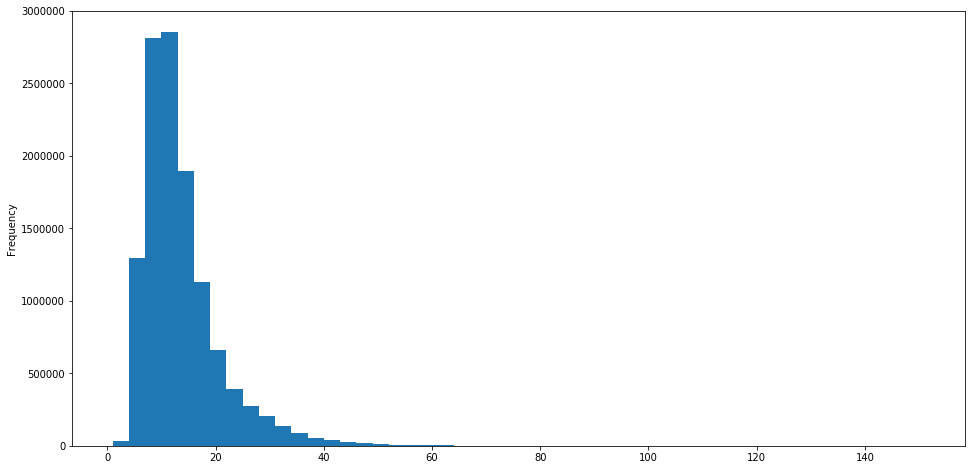

In [6]:
df['name_len'].plot.hist(bins=50, figsize=(16, 8))

In [7]:
# flatten all trigrams
name_trigrams_df = pd.DataFrame(
    {'trigram': [item for sublist in df['name_trigrams'] for item in sublist]})

# count the # counts for each trigram
name_trigrams_df = name_trigrams_df.groupby('trigram').size().sort_values(
    ascending=False)

In [8]:
name_trigrams_df

trigram
ang        614040
an<IOS>    471828
ng<EOS>    448307
ter        398685
ong        390369
<IOS>ch    384520
ing        382187
and        361102
<BOS>ba    356463
el<IOS>    349530
<IOS>la    343828
<BOS>la    337249
<BOS>sa    331226
en<EOS>    316181
ran        314887
er<IOS>    311149
ill        310582
<IOS>de    308362
ch<EOS>    307107
<BOS>ma    306072
an<EOS>    303811
ng<IOS>    303123
ree        299303
ist        295862
al<IOS>    294362
on<IOS>    291001
cho        286737
ent        277003
cha        269273
han        267131
            ...  
pqī             1
pqr             1
pqn             1
pqi             1
pqe             1
pqd             1
pqc             1
prų             1
prơ             1
ps.             1
ptä             1
ptš             1
ptō             1
ptē             1
ptč             1
ptü             1
ptö             1
ptï             1
ptæ             1
pt@             1
ps1             1
pt:             1
pt6             1
pt4             1
pt

In [9]:
print('Total Number of Toponym Trigrams: {}'.format(len(name_trigrams_df)))

Total Number of Toponym Trigrams: 125352


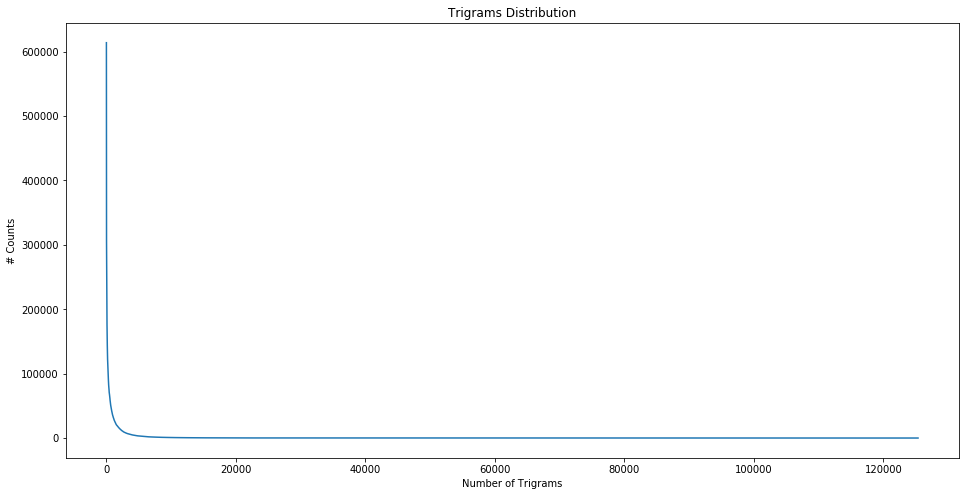

In [10]:
plt.figure(figsize=(16, 8))
plt.plot(name_trigrams_df.values)
plt.xlabel('Number of Trigrams')
plt.ylabel('# Counts')
plt.title('Trigrams Distribution')

del name_trigrams_df

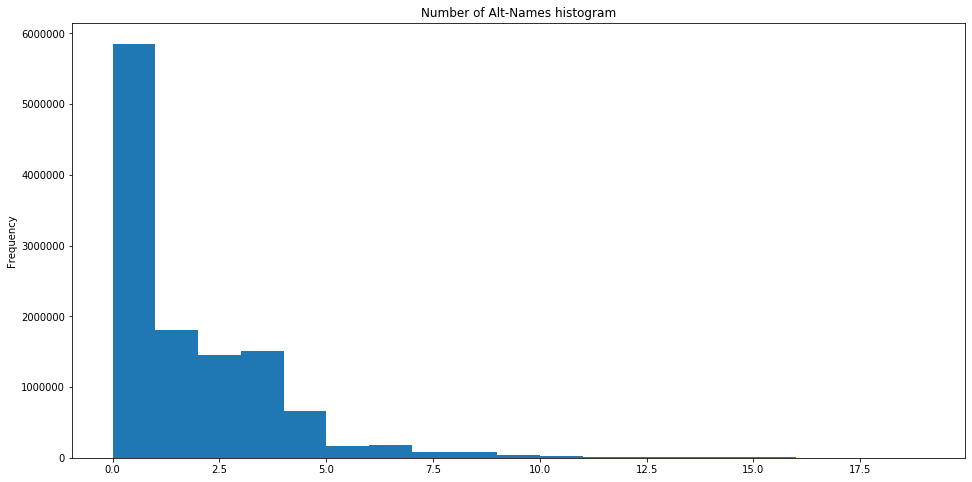

In [11]:
# plot histogram for the number of alternate names
df['n_alternates'].plot.hist(bins=range(20), figsize=(16, 8), 
                             title='Number of Alt-Names histogram',)

In [12]:
print(df['n_name_trigrams'].describe(percentiles=[.10, .25, .5, .75, .90]))

count    1.194737e+07
mean     1.216658e+01
std      6.275184e+00
min      1.000000e+00
10%      6.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
90%      2.000000e+01
max      1.340000e+02
Name: n_name_trigrams, dtype: float64


In [13]:
# country code stats
df.groupby('country_code')['country_code'].size().sort_values(ascending=False)

country_code
US    2237565
CN     777591
IN     648819
NO     605528
MX     450169
ID     385192
RU     357796
CA     313410
TH     255185
IR     236636
PK     225873
AU     213526
DE     197181
MA     152971
FR     146720
NP     134189
KR     131710
IT     118939
BR     114886
PE     104827
ZA     102844
JP      99771
SE      96305
PH      93235
YE      92462
FI      86204
ES      85418
TR      85078
CH      82264
CO      78065
       ...   
BQ        462
DM        421
SZ        418
KY        366
TV        341
NU        324
MS        298
UM        280
GI        251
AI        234
MF        227
SX        198
MO        173
IM        165
BL        132
TK        118
IO        118
NR        108
MC         99
HM         97
CX         87
NF         81
SM         71
CC         60
BV         47
PN         41
VA         26
AN          2
CS          2
YU          1
Name: country_code, Length: 252, dtype: int64

In [14]:
chars = set()
for name in tqdm(df['name']):
    name = set(name.lower())
    chars.update(name)

100%|██████████| 11947366/11947366 [00:14<00:00, 843813.62it/s]


In [15]:
print('Number of Unique Characters in Names: {}'.format(len(chars)))

Number of Unique Characters in Names: 791


In [16]:
for l in tqdm(df['alternate_names']):
    if l:
        for alt_name in l:
            alt_name = set(alt_name)
            chars.update(name)

100%|██████████| 11947366/11947366 [00:42<00:00, 279968.02it/s]


In [17]:
print('Number of Unique Characters in all corpora: {}'.format(len(chars)))

Number of Unique Characters in all corpora: 791


In [18]:
def get_distances(toponym: str, alternates: list, gid: str):
    """

    :param toponym:
    :param alternates:
    :param gid:
    :return:
    """
    out = list()

    if alternates:
        name_tokens = toponym.split()

        for alt in alternates:
            char_dist = editdistance.eval(toponym, alt)

            alt_tokens = alt.split()

            tokens_dist = editdistance.eval(name_tokens, alt_tokens)

            out.append({'anchor': toponym,
                        'alternate': alt,
                        'char_distance': char_dist,
                        'tokens_distance': tokens_dist,
                        'n_name_tokens': len(name_tokens),
                        'n_alt_name_tokens': len(alt_tokens),
                        'gid': gid})

    return out

In [19]:
df = df[['name', 'alternate_names', 'geonameid']]

In [20]:
alternates = list()

for row in tqdm(df.iterrows(), total=len(df)):
    doc = row[1]
    res = get_distances(doc['name'],
                        doc['alternate_names'],
                        doc['geonameid'])
    alternates.extend(res)

100%|██████████| 11947366/11947366 [22:33<00:00, 8825.48it/s]


In [21]:
del df

In [22]:
cols = [
    'gid',
    'anchor',
    'alternate',
    'len_anchor',
    'len_alternate',
    'n_name_tokens',
    'n_alt_name_tokens',
    'char_distance',
    'tokens_distance',
    'char_distance_prc',
    'tokens_distance_prc']

In [23]:
distances_df = pd.DataFrame(alternates)
distances_df['len_anchor'] = distances_df['anchor'].str.len()
distances_df['len_alternate'] = distances_df['alternate'].str.len()

distances_df['char_distance_prc'] = distances_df['char_distance'] / distances_df['len_anchor']
distances_df['tokens_distance_prc'] = distances_df['tokens_distance'] / distances_df['n_name_tokens']

distances_df = distances_df[cols]

distances_df.head()

,gid,anchor,alternate,len_anchor,len_alternate,n_name_tokens,n_alt_name_tokens,char_distance,tokens_distance,char_distance_prc,tokens_distance_prc
0,2986043,pic de font blanca,pic de font blanca,18,18,4,4,0,0,0.000000,0.00
1,2986043,pic de font blanca,pic du port,18,11,4,3,10,3,0.555556,0.75
2,2994701,roc mélé,roc mele,8,8,2,2,2,1,0.250000,0.50
3,2994701,roc mélé,roc meler,8,9,2,2,3,1,0.375000,0.50
4,2994701,roc mélé,roc mélé,8,8,2,2,0,0,0.000000,0.00


In [24]:
distances_path = '../data/toponym_distances.csv'

In [25]:
distances_df.to_csv(distances_path, encoding='utf-8', index=False)